## Road signs classifier

**Artur Skowroński 411423**\
**Szymon Socha [no_index]**

The aim of our project, is to create the most optimal model possible that can recognise individual road signs.
To do this, we used the publicly available dataset [GTSRB - German Traffic Sign Recognition Benchmark](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign) containing more than 50,000 images of 43 traffic signs.
In order to test which of the algorithms for the image classification problem works best, we decided to use the following algorithms:
- RandomForest
- LightGBM (we are aware that we discussed another boosting model in class - XGBoost, however this one is definitely faster)
- Convolutional Neural Networks

Due to the fact that the dataset we have chosen is quite large and, in addition, we will be using neural networks, we have decided that we will use the resources of Google Drive, to which we can directly download images from Kaggle, and Google Colab, which will help us with faster calculations, without burdening the local machine.

With this in mind, we also include [instruction](https://medium.com/analytics-vidhya/how-to-download-kaggle-datasets-into-google-colab-via-google-drive-dcb348d7af07) on how to directly link a Google Drive account to a Kaggle account for our work.


#### 1. Import libraries

In [1]:
# Data analysis
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Image preprocessing/data preparation
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Modelling

import tensorflow as tf
from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Rescaling, AveragePooling2D, Dropout


# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Validation metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

# Model savings
import joblib
import pickle
from keras.models import load_model

from matplotlib import style
style.use('fivethirtyeight')
np.random.seed(42)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
os.chdir("/content/drive/MyDrive/road-signs-NN")

Below, we inserted the code which helped us upload the data directly from Kaggle into Google Drive.

In [ ]:
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/road-signs-NN"

# %cd /content/drive/MyDrive/road-signs-NN

# !kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign --unzip

In [ ]:
# %ls

kaggle.json  Meta/     test/  Test.csv  Train/     Untitled0.ipynb
meta/        Meta.csv  Test/  train/    Train.csv


**Setting parameters**

In [3]:
# Paths
train_path = '/content/drive/MyDrive/road-signs-NN/Train'
test_path = '/content/drive/MyDrive/road-signs-NN/Test'

# Resizing the images to 32x32x1
IMG_HEIGHT = 32
IMG_WIDTH = 32

# Total number of categories
NUM_CATEGORIES = len(os.listdir(train_path))
print(f'Dataset containts {NUM_CATEGORIES} different road signs.')

Dataset containts 43 different road signs.


Below, we will name our each road sign.

In [4]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

#### 2. Exploratory Data Analysis

In order to understand the distribution of the data, we have two helpful datasets in csv files.
Let's see how many pictures do we have in our datasets.

In [5]:
train_tabular = pd.read_csv('Train.csv')
test_tabular = pd.read_csv('Test.csv')

In [6]:
train_tabular.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [7]:
test_tabular.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [8]:
train_df_desc = train_tabular.Path.apply(lambda x: x.split("/")[1])\
                             .value_counts()\
                             .to_frame()\
                             .reset_index()\
                             .rename({"index": "Index", "Path": "Cnt"}, axis=1)

train_df_desc["Class"] = pd.Series(classes)
train_df_desc["Index"].astype("int32")
train_df_desc.head()

,Index,Cnt,Class
0,2,2250,Speed limit (20km/h)
1,1,2220,Speed limit (30km/h)
2,13,2160,Speed limit (50km/h)
3,12,2100,Speed limit (60km/h)
4,38,2070,Speed limit (70km/h)


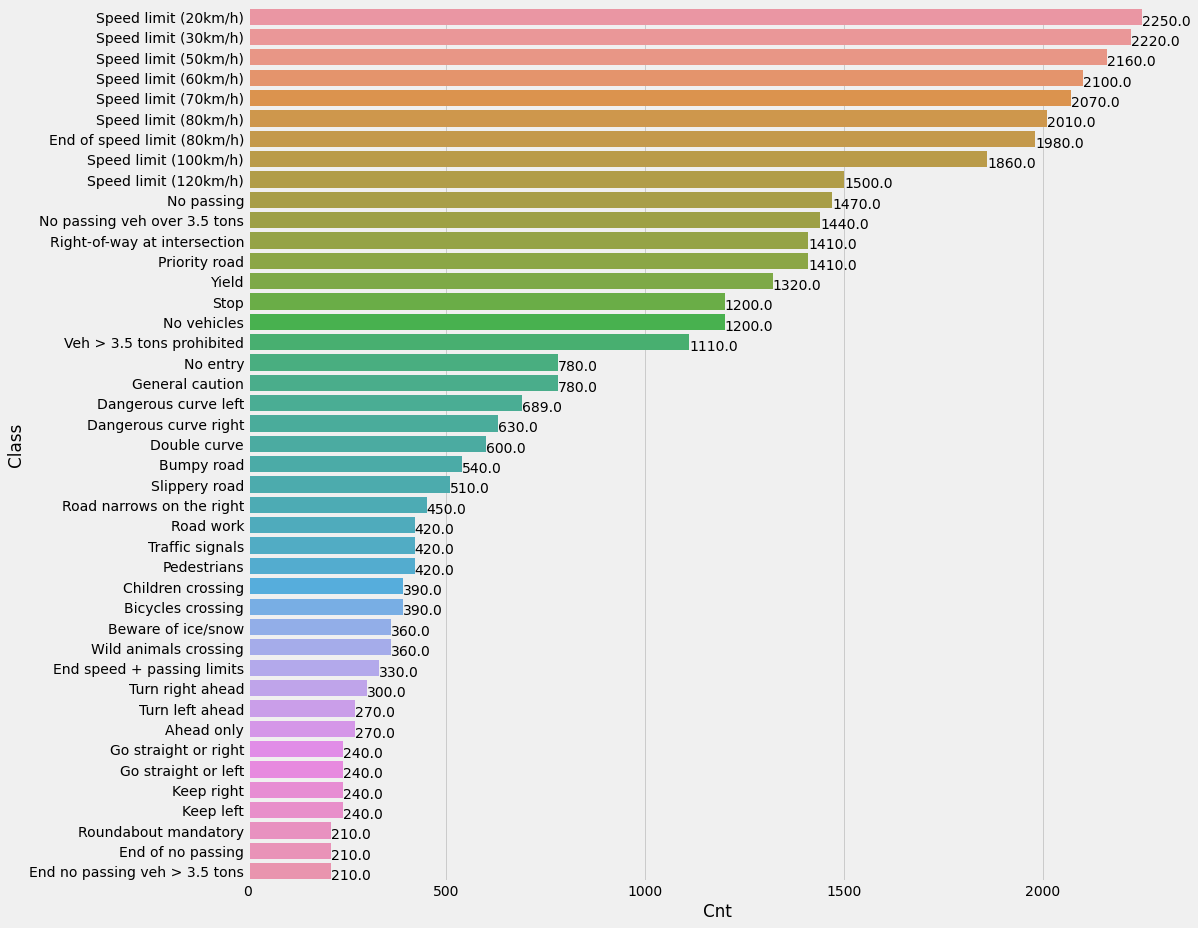

In [9]:
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.barplot(x='Cnt', y='Class', data=train_df_desc)
for p in ax.patches:
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()
                value = p.get_width()
                ax.text(x, y, value, ha="left")

plt.show()

Ok, so we see that the highest number of signs is connected with speed limit signs. This dataset is definitely unbalanced, so it might be worth to do some kind of data augmentation. Nevertheless, at this step we decided to not doing it, in order to check how our model will behave. \

Below we decided to show, two different signs. In the first case, the sign is quite obvious, so we assume, that our algorithm should not hvae any problem in recognising it. 
However, in the second example, on the first glance, it might be hard to estimate was sign is that.

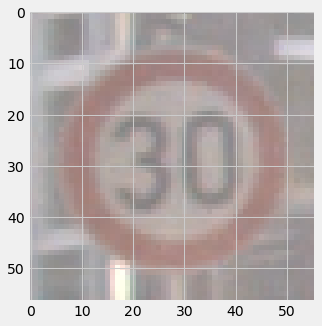

In [12]:
plt.figure(figsize=(10,5))
pic = Image.open(f'{train_path}/1/00001_00000_00000.png').convert('RGB')
plt.imshow(pic)

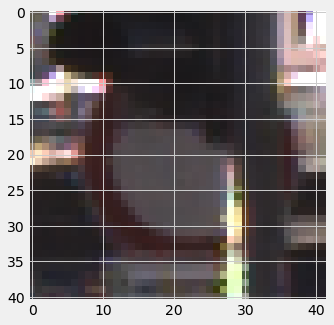

In [13]:
plt.figure(figsize=(10,5))
pic = Image.open(f'{train_path}/15/00015_00000_00000.png').convert('RGB')
plt.imshow(pic)

We see, that there are many different signs. Some are quite obvious, but other are even hard for human to recognise.

#### 3. Data preparation

Images will be rescaled to 32x32 resolution, all transformed to grayscale (single channel image).

In [10]:
# Retrieving the images and their labels 
from tqdm import tqdm
images_list = []
labels = []

for i in tqdm(range(NUM_CATEGORIES)):
    path = os.path.join(train_path, str(i))
    images = os.listdir(path)

    for no_image in images:
        try:
            pic = Image.open(path + '/'+ no_image).convert('L')
            image = pic.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
            pixels = np.array(image)
            image_ravel = pixels.ravel()
            images_list.append(image_ravel)
            labels.append(i)
        except:
            print("Error loading image")

# Converting lists into numpy arrays
images_list = np.array(images_list)
labels = np.array(labels)

100%|██████████| 43/43 [01:43<00:00,  2.40s/it]


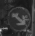

In [38]:
images = [file for file in os.listdir(test_path) if file.endswith('.png')]
Image.open(test_path + '/' + images[2]).convert('L')

We do the same with our test dataset.

In [11]:
images_list_test = []
labels_test = []

for i in tqdm(range(NUM_CATEGORIES)):
    images = [file for file in os.listdir(test_path) if file.endswith('.png')]

    for no_image in images:
        try:
            pic = Image.open(test_path + '/' + no_image).convert('L')
            image = pic.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
            pixels = np.array(image)
            image_ravel = pixels.ravel()
            images_list_test.append(image_ravel)
            labels_test.append(i)
        except:
            print("Error loading image")

# Converting lists into numpy arrays
X_test = np.array(images_list_test)
y_test = np.array(labels_test)

100%|██████████| 43/43 [16:44<00:00, 23.36s/it]


In [13]:
# Check if everything is OK
print(images_list.shape, labels.shape)

(39209, 1024) (39209,)


#### Spliting into train/valid

Because of the fact, that we don't have any validation data, we have to split training data intro train and valid data.

In [21]:
# Splitting training and testing dataset
X_train, X_valid, y_train, y_valid = train_test_split(images_list, labels, test_size=0.2, random_state=42)

# Displaying the shape after the split
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

# Converting the labels into one hot encoding
# y_train = to_categorical(y_train, 43)
# y_test = to_categorical(y_test, 43)

(31367, 1024) (7842, 1024) (31367,) (7842,)


#### Preview the images



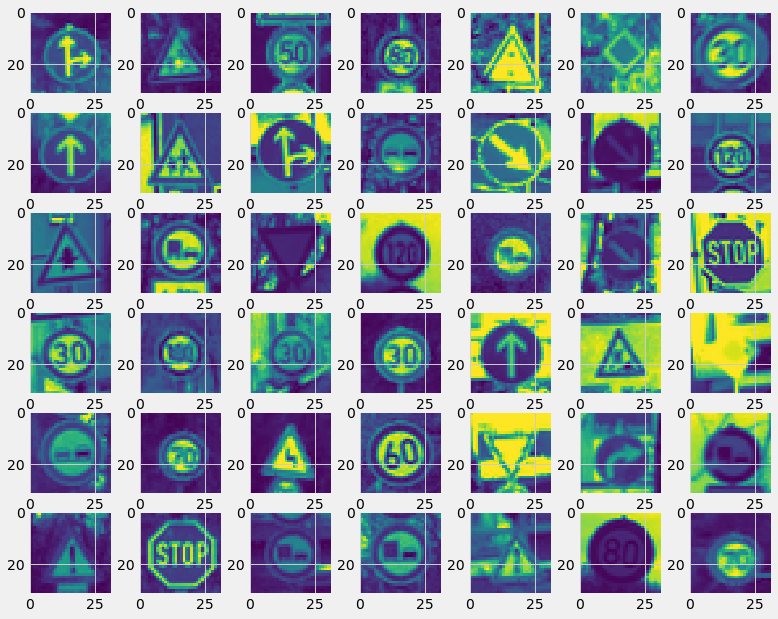

In [15]:
plt.figure(figsize=(12,10))
x, y = 7, 6
for i in range(42):  
    plt.subplot(y, x, i+1)
    plt.imshow(X_train[i].reshape((IMG_WIDTH, IMG_HEIGHT)), interpolation='nearest')
plt.show()

Based on above plot, we have successfully managed to convert our images to greyscale.

#### Additional preparations

In [22]:
# Normalization to values between 0 an 1

X_train = X_train/255.0
X_valid = X_valid/255.0
X_test = X_test/255.0

In [23]:
# Checking if all dimensions are correct

print('X_train shape:', X_train.shape)
print('X_valid shape:', X_valid.shape)
print('X_test shape:', X_test.shape)

X_train shape: (31367, 1024)
X_valid shape: (7842, 1024)
X_test shape: (543090, 1024)


In [24]:
# Reshaping

dim_to_reshape = X_train.shape[1]
X_train = X_train.reshape(X_train.shape[0], dim_to_reshape)
X_valid = X_valid.reshape(X_valid.shape[0], dim_to_reshape)
X_test = X_test.reshape(X_test.shape[0], dim_to_reshape)

y_train = y_train.reshape(-1, 1)
y_valid = y_valid.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [25]:
print('x_train shape:', X_train.shape)
print('x_test shape:', X_valid.shape)
print('x_test shape:', X_test.shape)

x_train shape: (31367, 1024)
x_test shape: (7842, 1024)
x_test shape: (543090, 1024)


#### 4. Modelling

After finding the best optimal hyperparameters for our each model, we will save it in order to not recalculating it, which will be very helpful.
What's more, especially in case of Neural Networks, the fitting time is taking so long, so we recommend to just upload are prepared earlier model.

##### 4.1. Random Forest

**NOTE** - It took us 90 minutes, to find the best params. We recommend to use pickled model.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = [
{'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 300, num = 6)], # The number of trees in the forest. # The number of features to consider when looking for the best split.
 'max_depth': [int(x) for x in np.linspace(2, 6, num = 4)],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4]} # The maximum depth of the tree.
]

grid_search_forest = RandomizedSearchCV(RandomForestClassifier(), param_grid, cv=2, scoring='accuracy')
grid_search_forest.fit(X_train, y_train.ravel())

KeyboardInterrupt: ignored

In [ ]:
import joblib
joblib.dump(grid_search_forest.best_estimator_, 'random_forest_best_est.pkl')

In [ ]:
loaded_rf_model = joblib.load('random_forest_best_est.pkl')
result = loaded_rf_model.score(X_valid, y_valid)
print(f'Random Forest accuracy: {100*np.round(result, 2)}%')

Random Forest accuracy: 61.0%


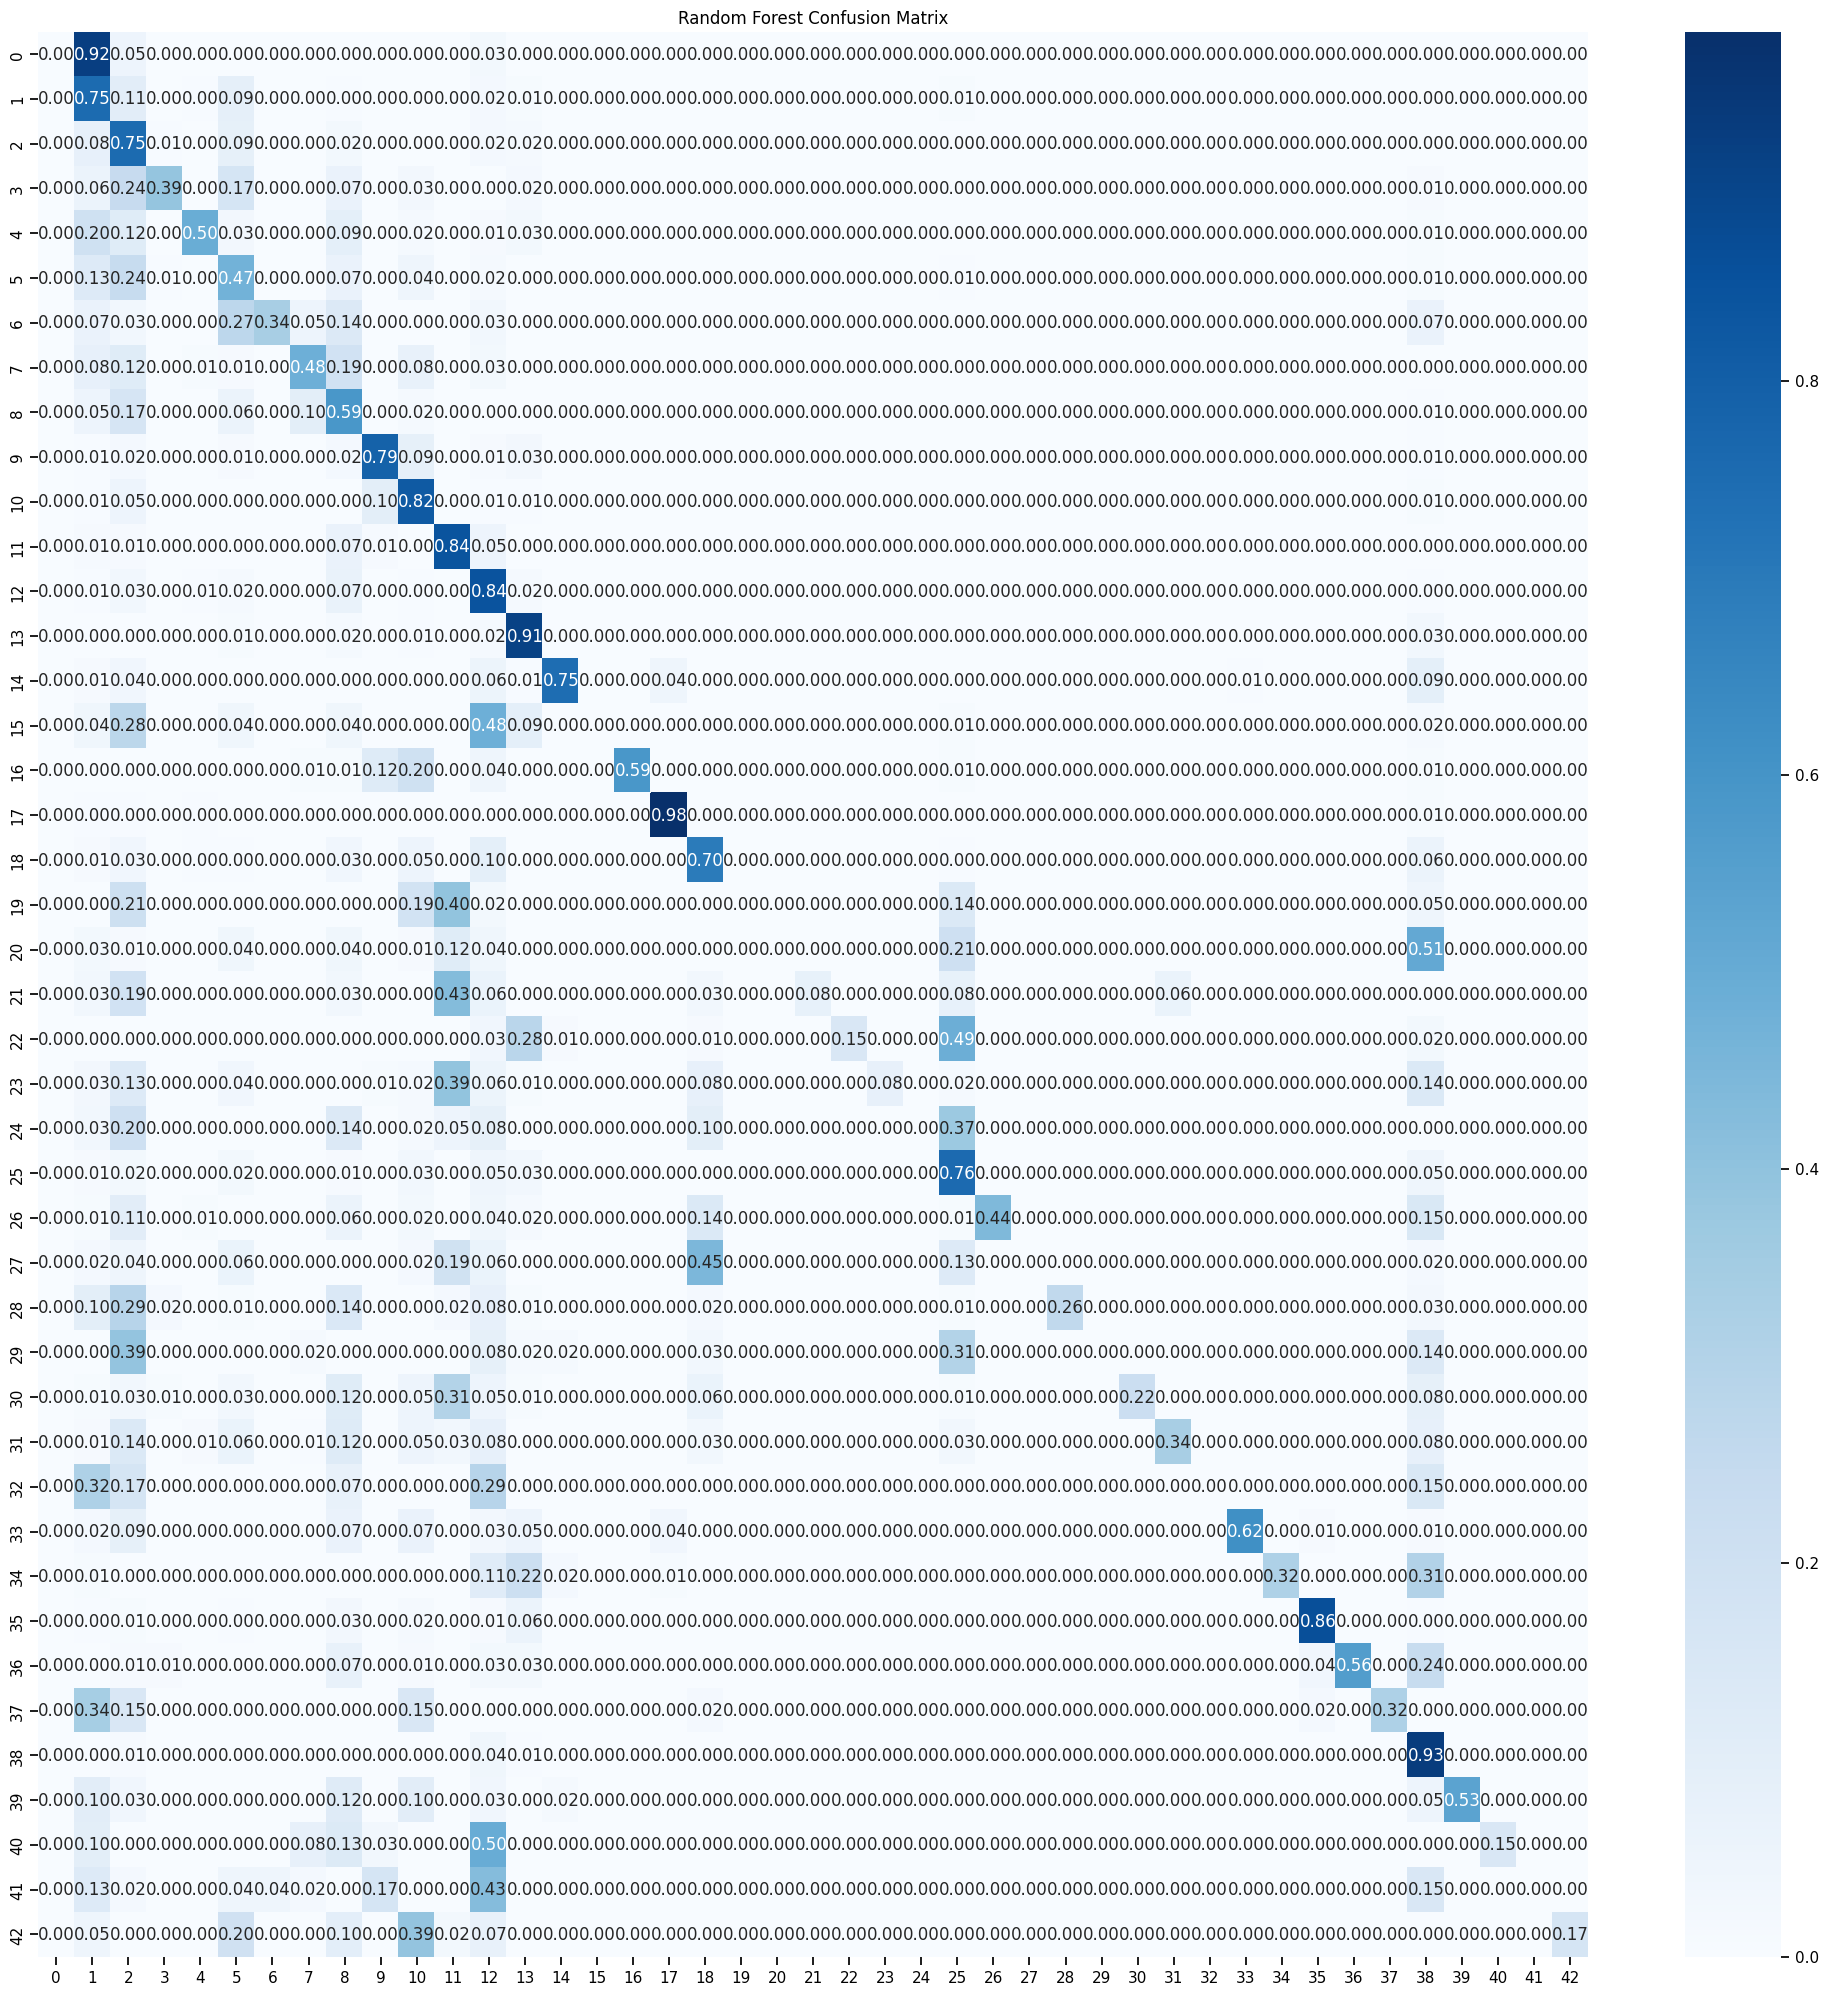

In [ ]:
# Calculate predictions

rf_predictions = loaded_rf_model.predict(X_test)
  
# creating a confusion matrix 
cm_rf = confusion_matrix(y_test, rf_predictions)
cm_rf = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(25,25))
sns.set_context("notebook")
sns.heatmap(cm_rf, annot = True, fmt='.2f', cmap="Blues").set_title("Random Forest Confusion Matrix")
plt.show()

In [95]:
# Classification report
# resource: https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report (adjusted to our needs)

def plot_classification_report(y_true, y_pred, figsize=(12, 12)):

    plt.figure(figsize=figsize)

    xticks = ['precision', 'recall', 'f1-score', 'support']
    yticks = list(np.unique(y_true))
    yticks += ['avg']

    rep = np.array(precision_recall_fscore_support(y_true, y_pred)).T
    avg = np.mean(rep, axis=0)
    avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    ax = sns.heatmap(rep,
                    annot=True, 
                    cbar=False, 
                    xticklabels=xticks, 
                    yticklabels=yticks,
                    ax=ax,
                    cmap="Reds",
                    fmt='g')
    ax.xaxis.set_ticks_position('top')

plot_classification_report(y_test, rf_predictions)

##### 4.2. LightGBM

In [ ]:
import lightgbm as lgb

param_grid = [
{'n_estimators': [10, 50, 100, 300], 
 'learning_rate': [0.0001, 0.001, 0.01],
 'subsample': [0.5, 0.7, 1.0],
 'max_depth': [3, 4, 5],
 'objective': ['multiclass'],
 'metric': ['multi_logloss']} 
]

grid_search_lgb = RandomizedSearchCV(lgb.LGBMClassifier(), param_grid, cv=2, scoring='accuracy')
grid_search_lgb.fit(X_train, y_train.ravel())

KeyboardInterrupt: ignored

In [ ]:
import joblib
joblib.dump(grid_search_lgb.best_estimator_, 'lightgbm_best_est.pkl')

['lightgbm_best_est.pkl']

In [ ]:
loaded_lgb_model = joblib.load('lightgbm_best_est.pkl')
result = loaded_lgb_model.score(X_valid, y_valid)
print(f'Light GBM accuracy: {100*np.round(result, 2)}%')

Light GBM accuracy: 1.0%


In [ ]:
from xgboost import XGBClassifier
test = XGBClassifier(objective='multiclass', metric='multi_logloss', n_jobs=-1).fit(X_train, y_train.reshape(-1,))

KeyboardInterrupt: ignored

In [ ]:
# Calculate predictions
import seaborn as sns
lgb_predictions = loaded_lgb_model.predict(X_test)
lgb_predictions = lgb_predictions.astype('float') / lgb_predictions.sum(axis=1)[:, np.newaxis]
# creating a confusion matrix 
cm_lgb = confusion_matrix(y_test, lgb_predictions)

plt.figure(figsize=(25,25))
sns.set_context("notebook")
sns.heatmap(cm_lgb, annot = True, fmt='.2f', cmap="Blues").set_title("LightGBM Confusion Matrix")
plt.show()

AxisError: ignored

##### 4.3. Neural Networks - CNN

In case of Neural Networks, the data should be transformed a little bit:
- X labels should be in this shape: (records, image_width, image_height, channels)
- we have multiclassification problem, so model compile process should consists of loss = 'categorical_crossentropy', that's why our y variables, should be changed into one hot encoding

In [26]:
# reshaping for cnn (keras requires input to be three-dimensional - in case of images with colours)

X_train = X_train.reshape(X_train.shape[0], 32, 32,1)
X_valid = X_valid.reshape(X_valid.shape[0], 32, 32,1)
X_test = X_test.reshape(X_test.shape[0], 32, 32,1)

y_train = to_categorical(y_train, 43)
y_valid = to_categorical(y_valid, 43)
y_test = to_categorical(y_test, 43)

In order to test the various possibilities for CNN, with the aim of achieving the best possible model, we decided to build up several networks based on LeNet-5 architecture, which is the one of the first architectures build in 1998 by Yann LeCun et al.

For our needs, we dropped two convolutional layers and one pooling layer. 
What's more we decided to build our model based on different number of filters.
This trick enabled us to get 5 different models.

In [14]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)

import warnings
warnings.filterwarnings("ignore")

from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Rescaling, AveragePooling2D, Dropout

filters = [3, 5, 9, 13, 15]
models = {}

for key, value in enumerate(filters):

    try:
        print(f'Calculation of the model {key} with {value} filters has just started!')

        tmp_model = Sequential()
        tmp_model.add(Rescaling(1, input_shape=(32, 32, 1)))
        tmp_model.add(Conv2D(6, kernel_size=value, padding='same', activation='relu'))
        tmp_model.add(AveragePooling2D(pool_size=2))
        tmp_model.add(Dropout(0.2))
        tmp_model.add(Flatten())
        tmp_model.add(Dense(130, activation='relu'))
        tmp_model.add(Dense(43, activation='softmax'))
        tmp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        print(f'Calculation of the model {key} with {value} filters has successfully finished!')
        print('-'*30)
    except:
        print('Something went wrong !')

    models[f'model_{key}'] = tmp_model

Calculation of the model 0 with 3 filters has just started!
Calculation of the model 0 with 3 filters has successfully finished!
------------------------------
Calculation of the model 1 with 5 filters has just started!
Calculation of the model 1 with 5 filters has successfully finished!
------------------------------
Calculation of the model 2 with 9 filters has just started!
Calculation of the model 2 with 9 filters has successfully finished!
------------------------------
Calculation of the model 3 with 13 filters has just started!
Calculation of the model 3 with 13 filters has successfully finished!
------------------------------
Calculation of the model 4 with 15 filters has just started!
Calculation of the model 4 with 15 filters has successfully finished!
------------------------------


In an ideal world, we would not have the opportunity to see what a testing collection looks like. Therefore, our model, will be tuned for loss minimisation, i.e. when there is no fate drop in the next three epochs, our model will automatically stop further back-propagation and save the trained model.

**NOTE**, it took around 3 hours on google colab to fit the models. Nonetheless, we have already included the recalculated best model below, which we will rely on in the further stages of model verification.

In [15]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
checkpoint_callback = ModelCheckpoint(f'CNN_model_test.h5', monitor='loss', verbose=1, save_best_only=True, mode='min')
epochs = 50

test = models[f'model_2'].fit(X_train, 
                                y_train,
                                epochs = epochs,
                                validation_data=(X_valid, y_valid),
                                callbacks = [callback, checkpoint_callback],
                                verbose=0)
    
# print(f'''Model {i} has succesfully being fitted!
#           Total number of epochs is equal to {len(history[f'model_{i}_history'].history['loss'])}
#           The highest training accuracy is equal to {max(history[f'model_{i}_history'].history['accuracy'])}.
#           The highest validation accuracy is equal to {max(history[f'model_{i}_history'].history['val_accuracy'])}.


Epoch 1: loss improved from inf to 1.52170, saving model to CNN_model_test.h5

Epoch 2: loss improved from 1.52170 to 0.52222, saving model to CNN_model_test.h5

Epoch 3: loss improved from 0.52222 to 0.35040, saving model to CNN_model_test.h5

Epoch 4: loss improved from 0.35040 to 0.26512, saving model to CNN_model_test.h5

Epoch 5: loss improved from 0.26512 to 0.22286, saving model to CNN_model_test.h5

Epoch 6: loss improved from 0.22286 to 0.18800, saving model to CNN_model_test.h5

Epoch 7: loss improved from 0.18800 to 0.16025, saving model to CNN_model_test.h5

Epoch 8: loss improved from 0.16025 to 0.13765, saving model to CNN_model_test.h5

Epoch 9: loss improved from 0.13765 to 0.12362, saving model to CNN_model_test.h5

Epoch 10: loss improved from 0.12362 to 0.10912, saving model to CNN_model_test.h5

Epoch 11: loss improved from 0.10912 to 0.10128, saving model to CNN_model_test.h5

Epoch 12: loss improved from 0.10128 to 0.09461, saving model to CNN_model_test.h5

Epoc

**CAREFULL** CODE BELOW TAKES 3 HOURS

In [ ]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)

from keras.callbacks import EarlyStopping, ModelCheckpoint

epochs = 50
history = {}

for i in range(len(models)):
    # try:
    print(f'Model {i} is started being fitted!')
    print('')

    history[f'model_{i}_history'] = models[f'model_{i}'].fit(X_train, 
                                                              y_train,
                                                              epochs = epochs,
                                                              validation_data=(X_valid, y_valid),
                                                              callbacks = [EarlyStopping(monitor='loss', patience=3),
                                                                           ModelCheckpoint(f'CNN_model_{i}.h5', monitor='loss', verbose=0, save_best_only=True, mode='min')],
                                                              verbose=0)

    with open(f'CNN_model_history_{i}', 'wb') as file_pi:
        pickle.dump(history[f'model_{i}_history'].history, file_pi)
    
    print(f'''Model {i} has succesfully being fitted!
          Total number of epochs is equal to {len(history[f'model_{i}_history'].history['loss'])}
          The highest training accuracy is equal to {max(history[f'model_{i}_history'].history['accuracy'])}.
          The highest validation accuracy is equal to {max(history[f'model_{i}_history'].history['val_accuracy'])}.
          ''')
    print('-'*40)
    # except:
    print('Something went wrong')


Model 0 is started being fitted!

Model 0 has succesfully being fitted!
          Total number of epochs is equal to 50
          The highest training accuracy is equal to 0.9886186122894287.
          The highest validation accuracy is equal to 0.9770466685295105.
          
----------------------------------------
Something went wrong
Model 1 is started being fitted!

Model 1 has succesfully being fitted!
          Total number of epochs is equal to 32
          The highest training accuracy is equal to 0.9886505007743835.
          The highest validation accuracy is equal to 0.9822749495506287.
          
----------------------------------------
Something went wrong
Model 2 is started being fitted!

Model 2 has succesfully being fitted!
          Total number of epochs is equal to 37
          The highest training accuracy is equal to 0.9905952215194702.
          The highest validation accuracy is equal to 0.9826574921607971.
          
----------------------------------------
Some

The training accuracy has Model 3, but we decided to take into account Model 2, because of the fact that this model has the highest validation accuracy.

In [28]:
with open('CNN_model_history_2', "rb") as file_pi:
    history_final = pickle.load(file_pi)

In [27]:
model_final = load_model("CNN_model_2.h5")
model_final.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_22 (Rescaling)    (None, 32, 32, 1)         0         
                                                                 
 conv2d_33 (Conv2D)          (None, 32, 32, 6)         492       
                                                                 
 average_pooling2d_22 (Avera  (None, 16, 16, 6)        0         
 gePooling2D)                                                    
                                                                 
 dropout_22 (Dropout)        (None, 16, 16, 6)         0         
                                                                 
 flatten_32 (Flatten)        (None, 1536)              0         
                                                                 
 dense_64 (Dense)            (None, 130)               199810    
                                                     

The best seems to be model 2, thats why I will save it for later.

In [ ]:
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Rescaling, AveragePooling2D, Dropout

# Building the model
model = Sequential([
    Rescaling(1, input_shape=(32, 32, 1)),
    Conv2D(filters=6, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Conv2D(filters=120, kernel_size=(5, 5), activation='relu'),
    Dropout(0.2),
    Flatten(),
    Dense(units=120, activation='relu'),
    Dense(units=43, activation='softmax')
])

# Compilation of the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model architecture
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_12 (Rescaling)    (None, 32, 32, 1)         0         
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_11 (Avera  (None, 14, 14, 6)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_12 (Conv2D)          (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_12 (Avera  (None, 5, 5, 16)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_13 (Conv2D)          (None, 1, 1, 120)       

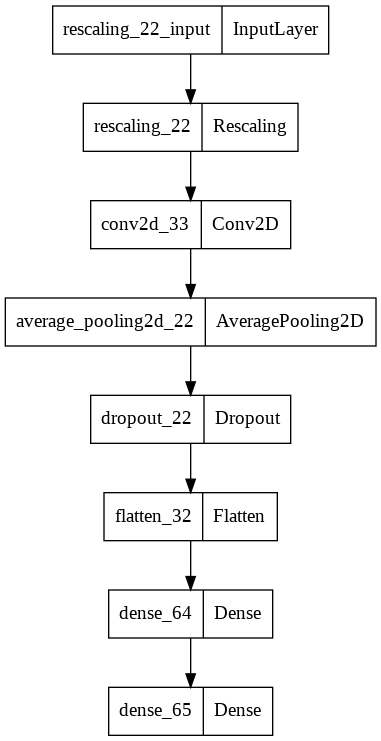

In [30]:
from keras.utils import plot_model
plot_model(model_final)

In [29]:
val_loss, val_acc = model_final.evaluate(X_valid, y_valid, verbose=2)
print('\nValidation accuracy:', val_acc)
print('\nValidation loss:', val_loss)

246/246 - 7s - loss: 0.1217 - accuracy: 0.9809 - 7s/epoch - 29ms/step

Validation accuracy: 0.9808722138404846

Validation loss: 0.12168281525373459


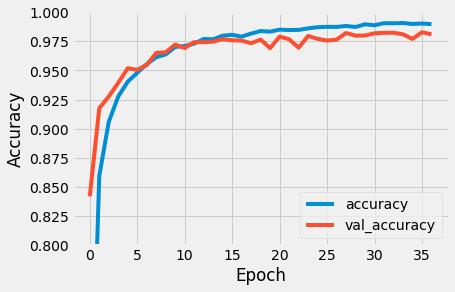

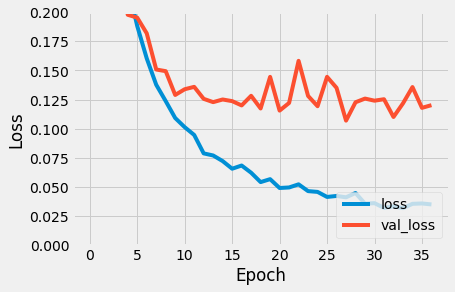

In [31]:
plt.figure(0)
plt.plot(history_final['accuracy'], label='accuracy')
plt.plot(history_final['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')

plt.figure(1)
plt.plot(history_final['loss'], label='loss')
plt.plot(history_final['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 0.2])
plt.legend(loc='lower right')

Based on the plot above, we see that accuracy line is quite similar to validation accuracy.

Significant difference is find in loss plots. We see, that around epoch 10, the validation scores is not lowering as much as loss score.

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15,15))
    plt.style.use('default')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
        
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [33]:
# creating a confusion matrix 
# cm_rf = confusion_matrix(y_test, rf_predictions)
# cm_rf = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis]

# plt.figure(figsize=(25,25))
# sns.set_context("notebook")
# sns.heatmap(cm_rf, annot = True, fmt='.2f', cmap="Blues").set_title("Random Forest Confusion Matrix")
# plt.show()

NameError: ignored

246/246 [==============================] - 11s 44ms/step


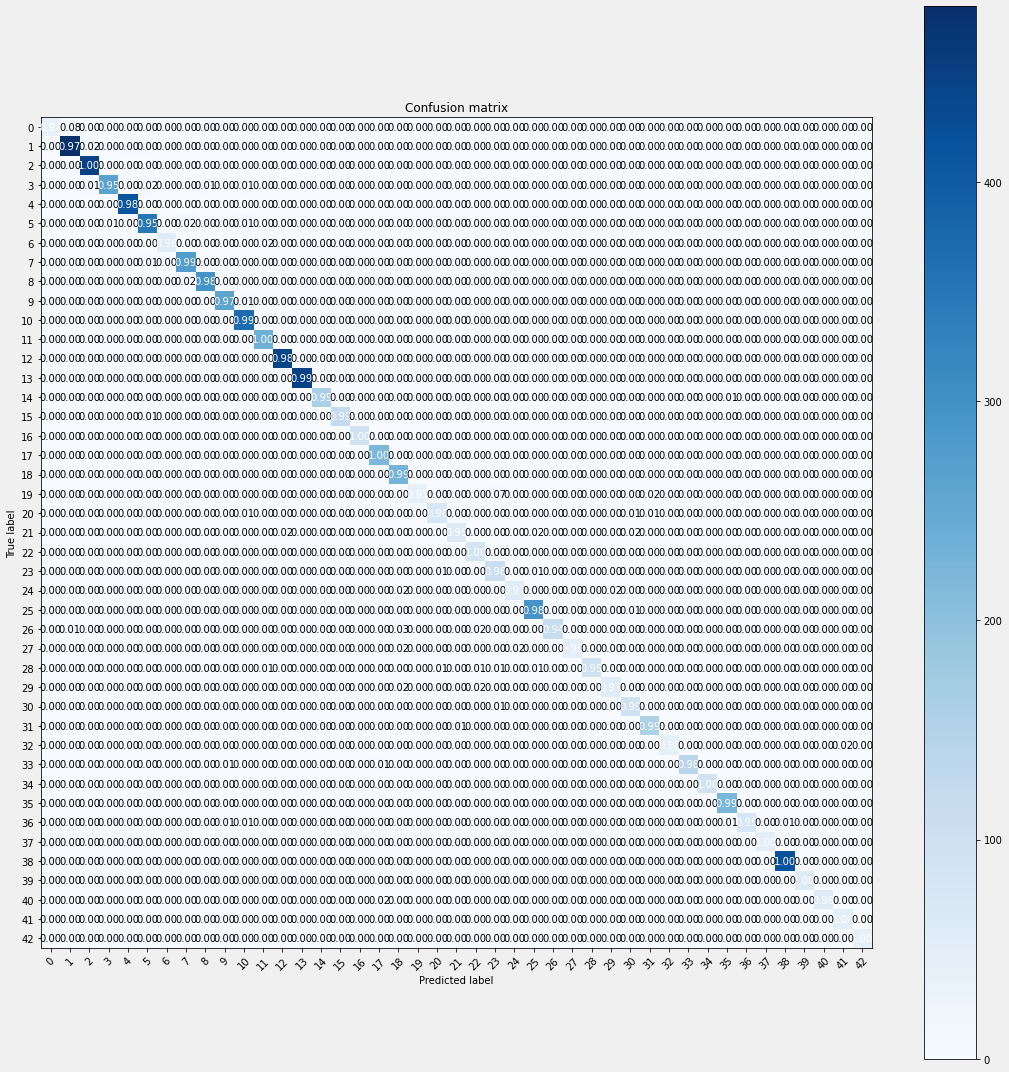

In [35]:
# Predict the values from the validation dataset
Y_pred = model_final.predict(X_valid)
# Convert one hot encoding to arg max
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to arg max
Y_true = np.argmax(y_valid, axis=1)
# plot the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(43))

In [24]:
#get the predictions for the test data
plot_classification_report(Y_true, Y_pred_classes)

NameError: ignored

In the last step, let's see how our model predicts the road signs.

246/246 [==============================] - 8s 31ms/step


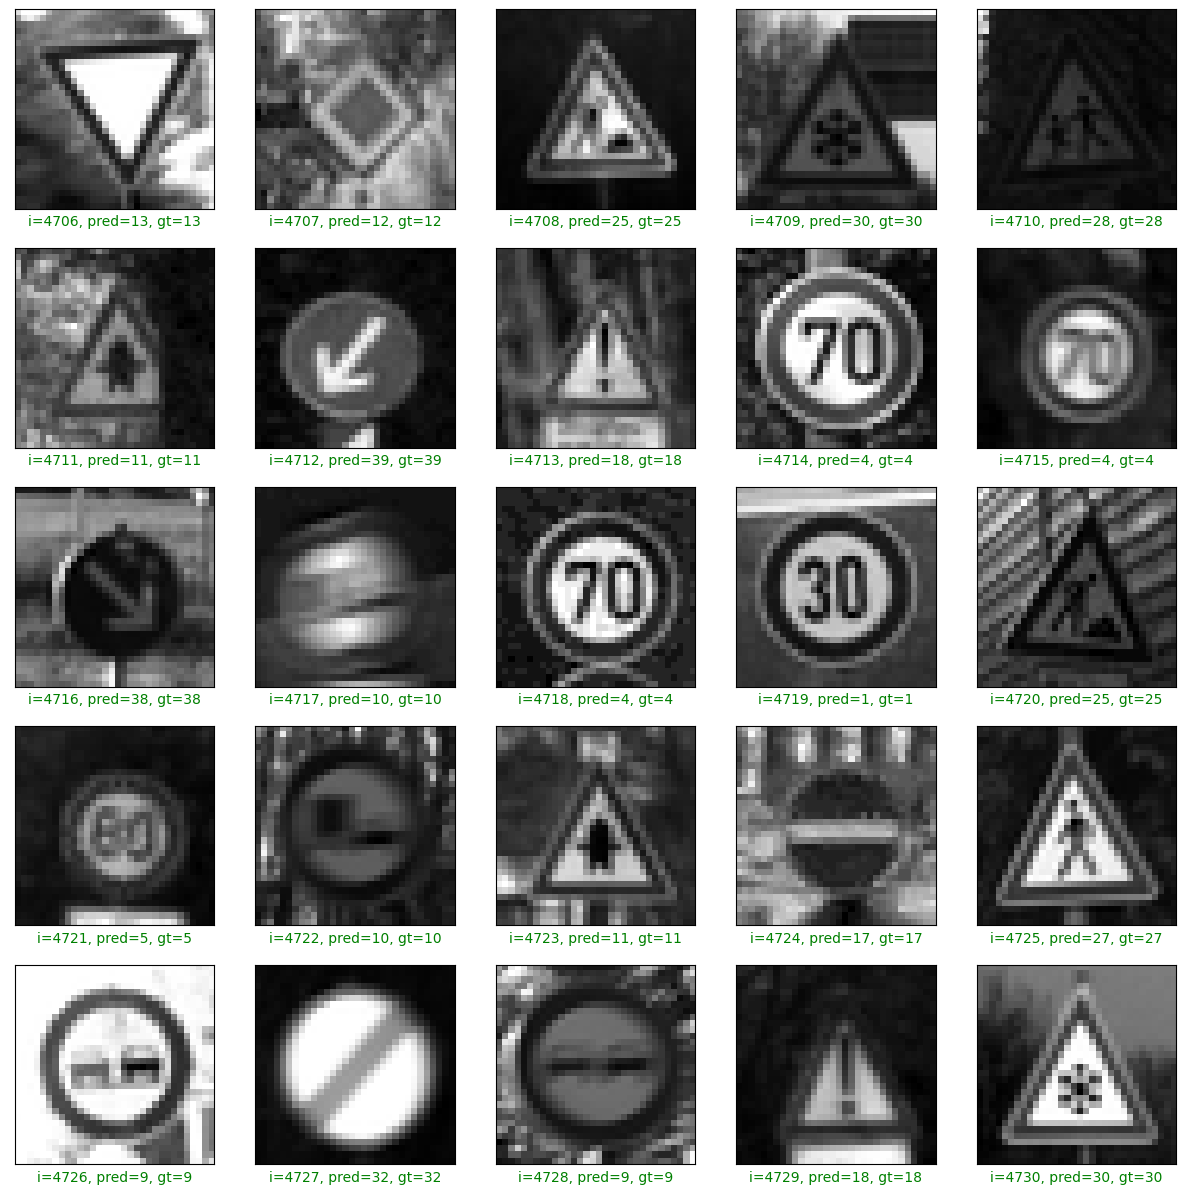

In [35]:
import random
preds = model_final.predict(X_test)

plt.figure(figsize=(15, 15))
start_index = random.randint(0, 7800)
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    pred = Y_pred_classes[start_index+i]
    gt = Y_true[start_index+i]
    
    col = 'g'
    if pred != gt:
        col = 'r'
    
    plt.xlabel('i={}, pred={}, gt={}'.format(start_index+i, pred, gt), color=col)
    plt.imshow(X_test[start_index+i].reshape((IMG_WIDTH, IMG_HEIGHT)), cmap='gray')
plt.show()

##### 4.4. Transfer learning - VGG16 (optional)

As an addendum, we also prepared implementations of the VGG16 architecture for our problem. Originally, this was built on RGB images, whereas our collection has greyscale. Therefore, to get around this problem, we added an additional convolution layer.

We decided to make this point purely optional, as in our case one epoch counts over two hours.
Nevertheless, we wanted to show that in today's world, architectures that are already built earlier and earlier are being used, which would prove to be effective in many cases.

Since we include this subsection purely as a curiosity, or as a way to implement an RGB-based architecture to the problem of grey images, we did not go into the results obtained from this method.

In [36]:
# https://stackoverflow.com/questions/51995977/how-can-i-use-a-pre-trained-neural-network-with-grayscale-images
from keras.applications.vgg16 import VGG16
from tensorflow.keras import Input

model_vgg19 = Sequential([
        Input(shape=(32, 32, 1)),
        Conv2D(3,(3,3),padding='same'),# add convolution layer to omit grayscale
        VGG16(weights='imagenet',include_top=False), 
        Flatten(),
        Dense(units=120, activation='relu'),
        Dense(units=43, activation='softmax')
        ])

model_vgg19.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model architecture

model_vgg19.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 3)         30        
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_5 (Flatten)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 120)               61560     
                                                                 
 dense_11 (Dense)            (None, 43)                5203      
                                                                 
Total params: 14,781,481
Trainable params: 14,781,481
Non-trainable params: 0
___________________________________________

In [37]:
history_vgg19 = model_vgg19.fit(X_train, 
                                y_train, 
                                epochs=5,
                                validation_data=(X_test, y_test),
                                batch_size = 216,
                                verbose=1)

Epoch 1/5


KeyboardInterrupt: ignored

#### 5. Summary

#### Resources

- http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf
- https://medium.com/@thomastracey/recognizing-traffic-signs-with-cnns-23a4ac66f7a7
- https://towardsdatascience.com/classification-of-traffic-signs-with-lenet-5-cnn-cb861289bd62
- https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
- https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/